# Algoritmo de simulação de artefatos metálicos

**Referências:**

- M. Sakamoto, Y. Hiasa, Y. Otake, M. Takao, Y. Suzuki, N. Sugano,and Y. Sato. Automated segmentation of hip and thigh muscles in metal artifact contaminated CT using CNN. page 31, 2019. [Link](https://github.com/NAIST-ICB/metal_artifact_simulation)
- G. T. Herman. Correction for beam hardening in computed tomography. Physics in Medicine and Biology, 24(1):81–106, 1979.
- Y. Zhang and H. Yu. Convolutional Neural Network Based Metal Artifact Reduction in X-Ray Computed Tomography. IEEE Transactions on Medical Imaging, 37(6):1370–1381, 2018.

****

## Descrição:

Algoritmo é responsável por fazer a inserção do metal e simular o artefato gerado durante o processo de aquisição de dados. Este algoritmo é descrito nas seguintes etapas:

1. Leitura da imagem original
1. Leitura da imagem do metal a ser inserido
1. Leitura da base de dados necessária para o algoritmo
1. Pré-processamento da imagem
1. Transformação de HU para Coef. Atenuação
1. Calibração do fantoma para a correção da água
1. Definição do polinômio de correção da água
1. Separação da imagem original em duas imagens: 1º com tecidos moles (água) e 2º com tecidos duros (ossos)
1. Equacionamento inicial das 3 figuras (2 segmentadas + metal) para gerar um sinograma único
1. Inserção do ruído de Poisson
1. Finalização do equacionamento do sinograma gerado
1. Adequação polinomial
1. Pós processamento da imagem
1. Transformação de Coef. Atenuação para HU

****

### 0. Inclusão das bibliotecas e funções

In [1]:
# Includes
import scipy.io as sio
from skimage.transform import radon, iradon
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pylibjpeg
from pydicom.data import get_testdata_file
import os
import pandas as pd
from scipy.special import expit

***
### 1. Leitura da imagem original

In [2]:
# Acessando dados do MatLab
data = sio.loadmat('sample_2.mat')
var = data['sample']

# Imagem de referência -> img
img = var['image']
img = img[0][0][:]

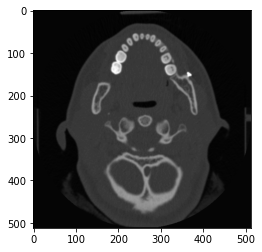

In [3]:
plt.imshow(img, cmap='gray')

***
### 2. Leitura da imagem do metal a ser inserido

In [4]:
# Imagem do metal -> img_metal
metal = var['metal']
img_metal = metal[0][0][:]

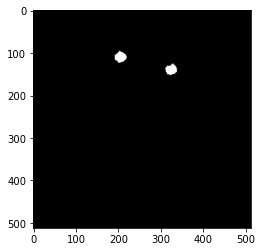

In [5]:
plt.imshow(img_metal, cmap='gray')

***
### 3. Leitura da base de dados necessária para o algoritmo

In [6]:
# Função de leitura do dataset de referência
def read_dataset(img_name):
    os.chdir('images_dcm/')
    filename = get_testdata_file(img_name)
    dataset = pydicom.dcmread(img_name)
    os.chdir('../')
    return dataset

In [7]:
# Unidade de Área (UA) por pixel -> pixel_size
pixel_size = var['pixel_size']
pixel_size = pixel_size[0][0][0][0]

# Valores de energia por intensidade -> energy_composition
data = pd.read_csv('xray_characteristic_data.csv')

# Array contendo índice das intensidades
energy_composition = np.linspace(0,119, 120).astype(int)

# Energia inicial (referência) do CT -> E0
E0 = 40

# Mu do ar -> mu_air
mu_air = 0

# Mu da água na energia inicial -> mu_water
mu_water = data.iloc[E0]['Water']

# Nome do metal -> metal_name
metal_name = 'Iron'

# Densidade do metal -> metal_density
metal_density = 6

# Limiares dos tecidos moles -> T1; e dos duros -> T2
T1 = 100
T2 = 1500

# Ordem do polinômio para correção da água -> polynomial_order_for_correction
polynomial_order_for_correction = 3

# Escada do ruído de Poisson -> noise_scale
noise_scale = 12

# Nº de ângulos para a RPF -> angle_num
angle_num = 1000

***
### 4. Pré processamento da imagem

In [8]:
# Retirando valores abaixo do limiar e considerando todos como ar (HU = -1000)
img[img <= -500] = -1000

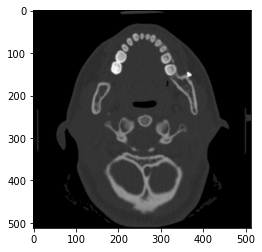

In [9]:
plt.imshow(img, cmap='gray')

***
### 5. Transformação de HU para Coef. Atenuação

In [10]:
# 3. Transformação de HU para Coef. Atenuação
def hu2mu(img, mu_water, mu_air):
    img = img/1000.0*(mu_water-mu_air) + mu_water
    return img

In [11]:
img_mu = hu2mu(img, mu_water, mu_air)

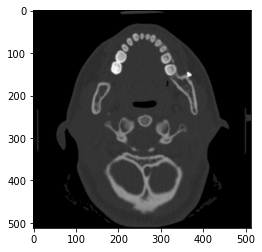

In [12]:
plt.imshow(img_mu, cmap='gray')

***
### 6. Calibração do fantoma para a correção da água

In [13]:
# 4. Transformada direta de Radon
def Radon(image, number_angles = 500):
    angles = np.linspace(0, 180, number_angles)
    sinogram = radon(image, theta = angles, circle = False, preserve_range=True)
    return sinogram

In [14]:
# Criando phantoma contendo espaço do objeto para preencher com água
def create_phantom(img, mu_water):
    xsize = img.shape[0]
    ysize = img.shape[1]
    x_array = np.linspace(-(xsize-1)/2,(xsize-1)/2, xsize)
    y_array = np.linspace(-(ysize-1)/2,(ysize-1)/2, ysize)
    X, Y = np.meshgrid(x_array, y_array)
    X_2 = np.power(X, 2)
    Y_2 = np.power(Y, 2)
    phantom = (X_2 + Y_2)< np.power(200,2)
    return (phantom * mu_water)

In [15]:
# Preenchendo sinograma do phantoma com água em relação a feixes monocromáticos
def fill_phantom_mono(phantom, angle_num, pixel_size):
    d_water = Radon(phantom, angle_num)
    d_water = d_water * pixel_size
    y = np.exp(-d_water)
    return -np.log(y)

In [16]:
# Preenchendo sinograma do phantoma com água em relação a feixes monocromáticos
def fill_phantom_poly(phantom, angle_num, pixel_size, energy_composition, E0):
    d_water = Radon(phantom, angle_num)
    d_water = d_water * pixel_size
    total_intensity = 0
    v = np.zeros((len(energy_composition), d_water.shape[0], d_water.shape[1]))
    m0_water = data.iloc[E0]['Water']
    for i in energy_composition:
        m_water = data.iloc[i]['Water']
        intensity = data.iloc[i]['Intensity']
        d_water_tmp = d_water*(m_water/m0_water)
        y = intensity * (np.exp(-d_water_tmp))
        v[i, :, :] = y
        total_intensity = total_intensity + intensity
    poly_p = np.sum(v, 0)
    return -np.log(poly_p/total_intensity)

In [17]:
phantom = create_phantom(img_mu, mu_water)

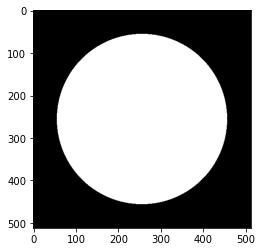

In [18]:
plt.imshow(phantom, cmap='gray')

In [19]:
p_mono = fill_phantom_mono(phantom, angle_num, pixel_size)

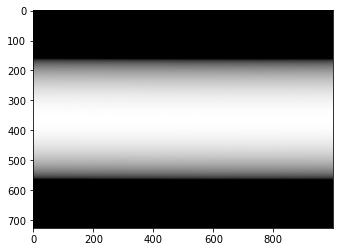

In [20]:
plt.imshow(p_mono, cmap='gray')

In [21]:
p_poly = fill_phantom_poly(phantom, angle_num, pixel_size, energy_composition, E0)

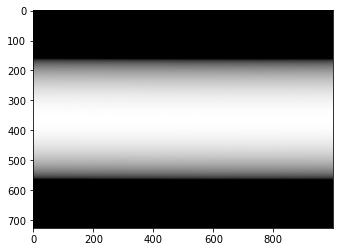

In [22]:
plt.imshow(p_mono, cmap='gray')

***
### 7. Definição do polinômio de correção da água

In [23]:
temp = np.polynomial.polynomial.polyfit(p_poly.flatten('F'), p_mono.flatten('F'), polynomial_order_for_correction)
corr_coeff = temp[::-1]

In [24]:
corr_coeff

array([-6.44765287e-03,  7.54075022e-02,  9.64657105e-01, -1.07943868e-04])

***
### 8. Separação da imagem original em duas imagens: 1º com tecidos moles (água) e 2º com tecidos duros (ossos)

In [25]:
def get_values_at_E0(E0, data, metal_name, metal_density):
    m0_water = data.iloc[E0]['Water']
    m0_metal = data.iloc[E0][metal_name]
    mu_water0 = m0_water * 1.0
    mu_metal0 = m0_metal * metal_density
    return [mu_water0, mu_metal0]

In [26]:
# Pegar valores de Mu na energia de referência
mu_water0, mu_metal0 = get_values_at_E0(E0, data, metal_name, metal_density)

In [27]:
# Transformar limiares de HU para Coef. Atenuação
T1 = hu2mu(T1, mu_water0, mu_air)
T2 = hu2mu(T2, mu_water0, mu_air)

In [28]:
# Separação da imagem em tecidos moles e duros
def threshold_based_weighting(img, T1, T2):
    w_bone = (img - T1) / (T2 - T1)
    w_bone = np.clip(w_bone, 0 , 1)
    bone = w_bone * img

    w_water = (T2 - img) / (T2 - T1)
    w_water = np.clip(w_water, 0 , 1)
    water = w_water * img
    
    return [water, bone]

In [29]:
x_water, x_bone = threshold_based_weighting(img_mu, T1, T2)

In [30]:
# Retirada do metal de ambas imagens
x_bone[img_metal>0] = 0
x_water[img_metal>0] = 0

In [31]:
# Adequação da imagem do metal para Coef. Atenuação
img_metal = img_metal * mu_metal0

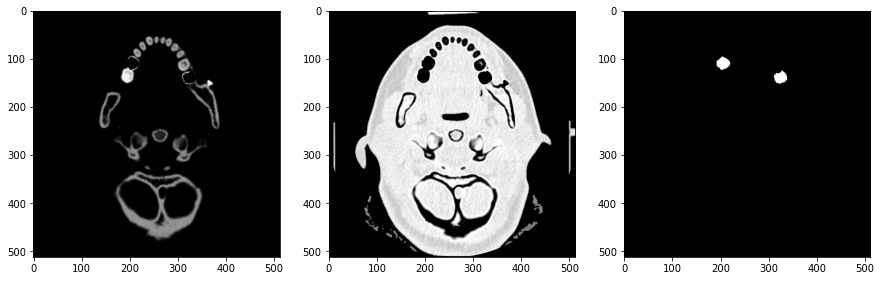

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(x_bone, cmap='gray')
ax2.imshow(x_water, cmap='gray')
ax3.imshow(img_metal, cmap='gray')

***
### 9. Equacionamento inicial das 3 figuras (2 segmentadas + metal) para gerar um sinograma único

In [33]:
# Transformada direta de Radon das 3 figuras (Parallel Beam)
d_water = Radon(x_water, angle_num)
d_bone = Radon(x_bone, angle_num)
d_metal = Radon(img_metal, angle_num)

In [34]:
# Transformação de pixel para UUA
d_metal = d_metal * pixel_size
d_bone = d_bone * pixel_size
d_water = d_water * pixel_size

In [35]:
# Inserção do metal com feixes monocromáticos
def metal_mono_ray(d_water, d_bone, d_metal, data, E0):
    intensity = data.iloc[E0]['Intensity']
    DRR = d_water + d_bone + d_metal
    y = intensity * (np.exp(-DRR))
    return [y, intensity]

In [36]:
# Caso monocromático
#y_mono, total_intensity_mono = metal_mono_ray(d_water, d_bone, d_metal, data, E0)
#plt.imshow(y_mono, cmap='gray')

In [38]:
# Inserção do metal com feixes policromático
def metal_poly_ray(d_water, d_bone, d_metal, data, E0, energy_composition, metal_name):
    total_intensity = 0
    v = np.zeros((len(energy_composition), d_water.shape[0], d_water.shape[1])) 
    m0_water = data.iloc[E0-1]['Water']
    m0_bone = data.iloc[E0-1]['Bone']
    m0_metal = data.iloc[E0-1][metal_name]
    
    for i in energy_composition:
        m_water = data.iloc[i]['Water']
        m_bone = data.iloc[i]['Bone']
        m_metal = data.iloc[i][metal_name]
        intensity = data.iloc[i]['Intensity']
        d_water_tmp = d_water*(m_water/m0_water)
        d_bone_tmp = d_bone*(m_bone/m0_bone)
        d_metal_tmp = d_metal*(m_metal/m0_metal)
        DRR = d_water_tmp + d_bone_tmp + d_metal_tmp
        y = intensity * (expit(-DRR))
        v[int(i), :, :] = y
        total_intensity = total_intensity + intensity
        
    return [sum(v, 0), total_intensity]

In [39]:
# Caso monocromático
y_poly, total_intensity_poly = metal_poly_ray(d_water, d_bone, d_metal, data, E0, energy_composition, metal_name)

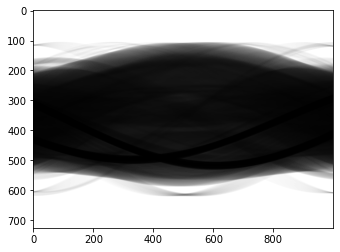

In [40]:
plt.imshow(y_poly, cmap='gray')

***
### 10. Inserção do ruído de Poisson

In [41]:
# Caso monocromático
#rng = np.random.default_rng()
#noisy_y_mono = np.float64(rng.poisson(lam=y_mono, size=None))
#noisy_y_mono[noisy_y_mono <= 0] = y_mono.min()
#noisy_y_mono = np.float64(random_noise(y_mono/(10**noise_scale), mode='poisson', clip = False))
#noisy_y_mono[noisy_y_mono <= 0] = 1e-100

In [43]:
# Caso policromático
rng = np.random.default_rng()
noisy_y_poly = np.float64(rng.poisson(lam=y_poly, size=None))
noisy_y_poly[noisy_y_poly <= 0] = y_poly.min()

***
### 11. Finalização do equacionamento do sinograma gerado e adequação polinomial

In [ ]:
# Caso monocromático
#p_mono = -np.log(noisy_y_mono/total_intensity_mono) #sinograma com ruído entra aqui
#p_final_mono = np.polyval(corr_coeff, p_mono)

In [44]:
# Caso policromático
p_poly = -np.log(noisy_y_poly/total_intensity_poly) #sinograma com ruído entra aqui
p_final_poly = np.polyval(corr_coeff, p_poly)

***
### 12. Transformada inversa de Radon

In [45]:
# Transformada inversa de Radon
def Iradon(sinogram, number_angles = 500):
    angles = np.linspace(0, 180, number_angles)
    fbp = iradon(sinogram, theta = angles, circle = False)
    return fbp

In [ ]:
# Caso monocromático
#sim_mono = Iradon(p_final_mono, angle_num)
#plt.imshow(sim_mono, cmap='gray')

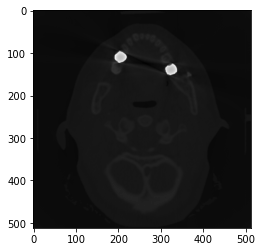

In [46]:
# Caso policromático
sim_poly = Iradon(p_final_poly, angle_num)
plt.imshow(sim_poly, cmap='gray')

***
### 13. Pós processamento da imagem

In [47]:
# Rotina de pós processamento - retirar valores "errados" e voltar de UA para pixel
def post_processing(sim, pixel_size):
    sim[sim < 0] = 0
    sim = sim / pixel_size
    return sim

In [ ]:
# Caso monocromático
#out_mono = post_processing(sim_mono, pixel_size)
#plt.imshow(out_mono, cmap='gray')

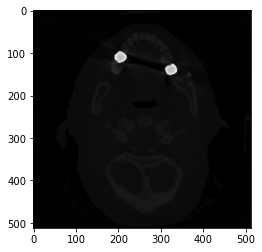

In [48]:
# Caso policromático
out_poly = post_processing(sim_poly, pixel_size)
plt.imshow(out_poly, cmap='gray')

***
### 14. Transformação de Coef. Atenuação para HU

In [49]:
# Transformação de Coef. Atenuação para HU
def mu2hu(img, mu_water, mu_air):
    img = 1000*(img-mu_water)/(mu_water-mu_air)
    return img

In [ ]:
# Caso monocromático
#final_mono = mu2hu(out_mono, mu_water, mu_air)
#fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
#ax1.imshow(final_mono, cmap='gray')

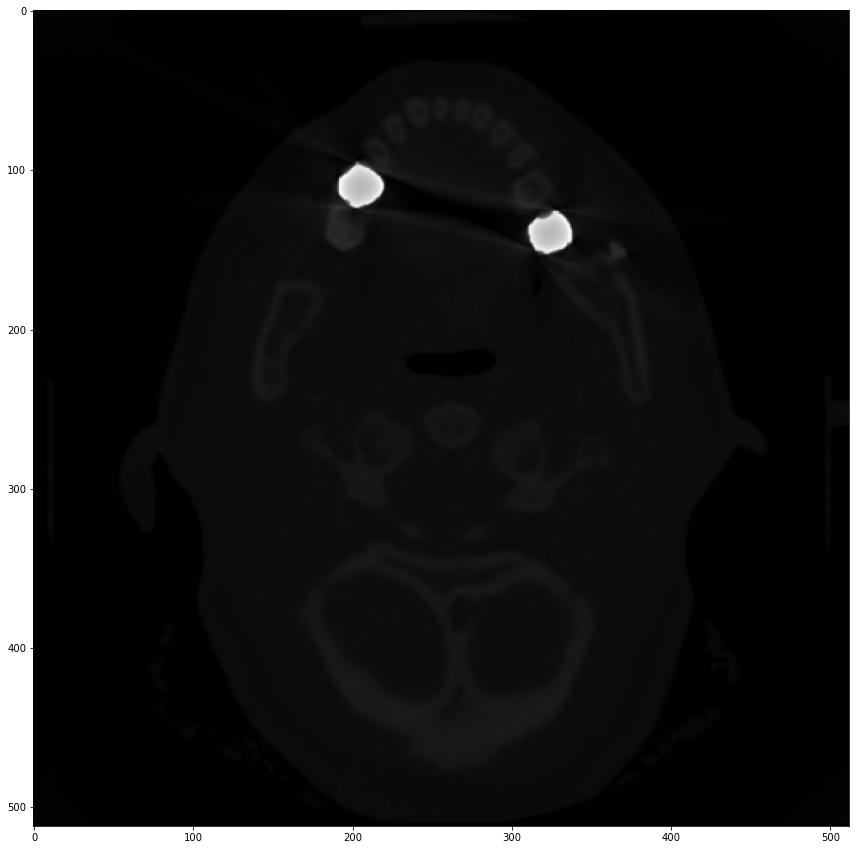

In [50]:
# Caso policromático
final_poly = mu2hu(out_poly, mu_water, mu_air)
fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(final_poly, cmap='gray')
plt.savefig("final_poly_with_poisson.png", dpi=300)
np.save('data_with_metal.npy', final_poly)